In [678]:
import numpy as np
import datetime as dt
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [ ]:
start = dt.datetime(2010, 1, 1)
end = dt.datetime.today()
capital = 10_000
years = (end - start).days/365.25
ticker = "^GSPC"

In [680]:
price = yf.download(ticker, start, end)

C:\Users\adelb\AppData\Local\Temp\ipykernel_13520\3341719244.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [681]:
price.columns = price.columns.get_level_values(0).rename(None)
price.drop(columns=["Low", "High", "Volume"], inplace=True)

In [682]:
price.head()

,Close,Open
Date,,
2010-01-04,6048.299805,5975.520020
2010-01-05,6031.859863,6043.939941
2010-01-06,6034.330078,6032.390137
2010-01-07,6019.359863,6016.799805
2010-01-08,6037.609863,6028.620117


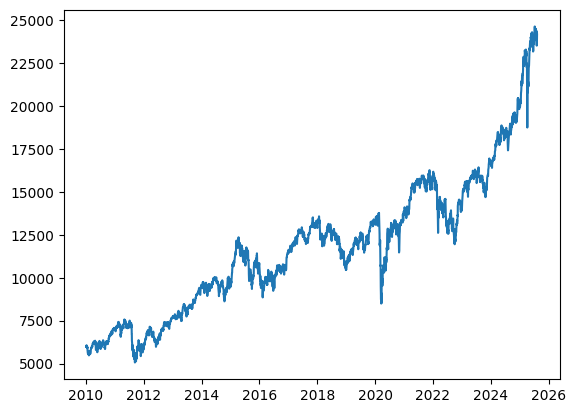

In [683]:
plt.plot(price["Open"])
plt.show()

In [684]:
price["Return"] = price["Close"]/price["Close"].shift(1)
price.loc[price.index[0], "Return"] = price["Close"][price.index[0]]/price["Open"][price.index[0]]
price.head()

,Close,Open,Return
Date,,,
2010-01-04,6048.299805,5975.520020,1.012180
2010-01-05,6031.859863,6043.939941,0.997282
2010-01-06,6034.330078,6032.390137,1.000410
2010-01-07,6019.359863,6016.799805,0.997519
2010-01-08,6037.609863,6028.620117,1.003032


In [685]:
price["HODL"] = capital * np.cumprod(price["Return"])

Annual growth rate :

\begin{equation*}
\text{Capital}_{end} = \text{Capital}_{start}(1+r)^n \quad \Longrightarrow \quad r=\left(\frac{\text{Capital}_{end}}{\text{Capital}_{start}}\right)^\frac1n - 1
\end{equation*}

In [686]:
hodl = {'roi': np.round((price["HODL"][-1]/price["HODL"][0] - 1) * 100, 2), 
        'cagr': np.round(((price["HODL"][-1]/price["HODL"][0])**(1/years) - 1) * 100, 2)}

C:\Users\adelb\AppData\Local\Temp\ipykernel_13520\3584126209.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hodl = {'roi': np.round((price["HODL"][-1]/price["HODL"][0] - 1) * 100, 2),
C:\Users\adelb\AppData\Local\Temp\ipykernel_13520\3584126209.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'cagr': np.round(((price["HODL"][-1]/price["HODL"][0])**(1/years) - 1) * 100, 2)}


In [687]:
price["HODL_Peak"] = np.maximum.accumulate(price["HODL"])
price["HODL_Drawdown"] = price["HODL"] - price["HODL_Peak"]

In [688]:
hodl["max_dd"] = np.round(np.min(price["HODL_Drawdown"]/price["HODL_Peak"]) * 100, 2)

In [689]:
print(hodl)

{'roi': np.float64(299.5), 'cagr': np.float64(9.28), 'max_dd': np.float64(-38.78)}


The trading stradegy relies on a "slow" moving average.

In [690]:
slow_period = 200
window = np.ones(slow_period)/slow_period
SMA = pd.Series(np.convolve(price["Open"], window, mode='valid'), index=price.index[slow_period - 1:])

In [691]:
price["SMA"] = SMA

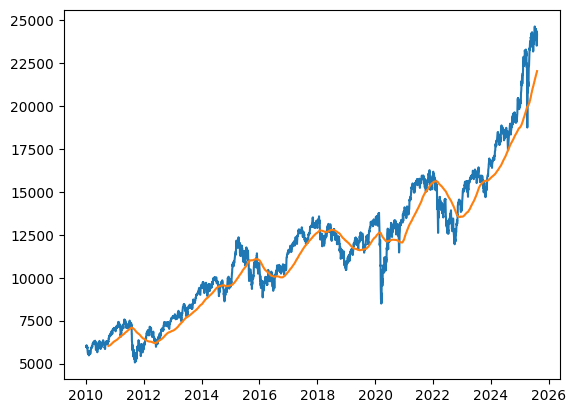

In [692]:
plt.plot(price["Open"])
plt.plot(price["SMA"])
plt.show()

In [693]:
price["in_market"] = (price["Open"] > price["SMA"])

In [694]:
price["SMA_Return"] = np.where(price["in_market"] == True, price["Return"], 1)
price["SMA_Capital"] = np.cumprod(price["SMA_Return"]) * capital

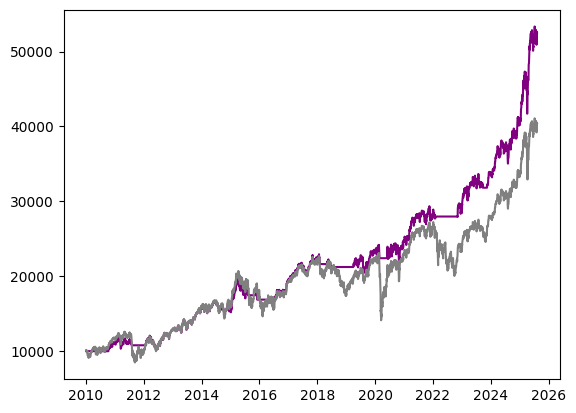

In [695]:
plt.plot(price["SMA_Capital"], color="purple")
plt.plot(price["HODL"], color='grey')
plt.show()

In [696]:
price["SMA_Peak"] = np.maximum.accumulate(price["SMA_Capital"])
price["SMA_Drawdown"] = price["SMA_Capital"] - price["SMA_Peak"]

In [697]:
startegy = {'roi': np.round((price["SMA_Capital"][-1]/price["SMA_Capital"][0] - 1) * 100, 2), 
        'cagr': np.round(((price["SMA_Capital"][-1]/price["SMA_Capital"][0])**(1/years) - 1) * 100, 2),
        'max_dd': np.round(np.min(price["SMA_Drawdown"]/price["SMA_Peak"]) * 100, 2)}

C:\Users\adelb\AppData\Local\Temp\ipykernel_13520\2471687048.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  startegy = {'roi': np.round((price["SMA_Capital"][-1]/price["SMA_Capital"][0] - 1) * 100, 2),
C:\Users\adelb\AppData\Local\Temp\ipykernel_13520\2471687048.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'cagr': np.round(((price["SMA_Capital"][-1]/price["SMA_Capital"][0])**(1/years) - 1) * 100, 2),


In [698]:
comp_table = pd.DataFrame([hodl, startegy], index=["HODL", "SMA Strategy"])
print(comp_table)

                 roi   cagr  max_dd
HODL          299.50   9.28  -38.78
SMA Strategy  425.06  11.21  -15.47


The second strategy involves 2 moving averages, one fast and one slow.

In [699]:
fast_period = 50
window = np.ones(fast_period)/fast_period
price["FMA"] = pd.Series(np.convolve(price["Open"], window, mode='valid'), index=price.index[fast_period - 1:])

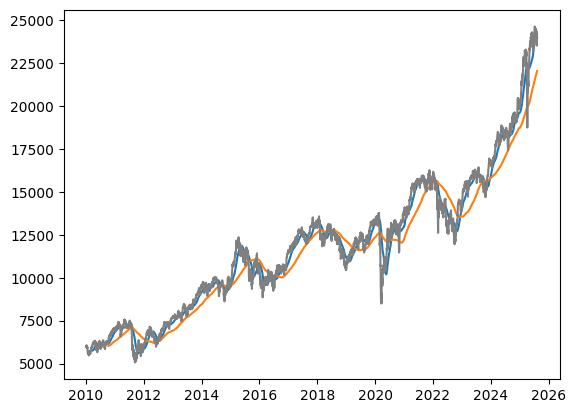

In [700]:
plt.plot(price["FMA"])
plt.plot(price["SMA"])
plt.plot(price["Open"], color="grey")
plt.show()

In [701]:
price["in_market_2"] = price["FMA"] > price["SMA"]
price["Strat_2_Return"] = np.where(price["in_market_2"] == True, price["Return"], 1)
price["Strat_2_Capital"] = np.cumprod(price["Strat_2_Return"]) * capital

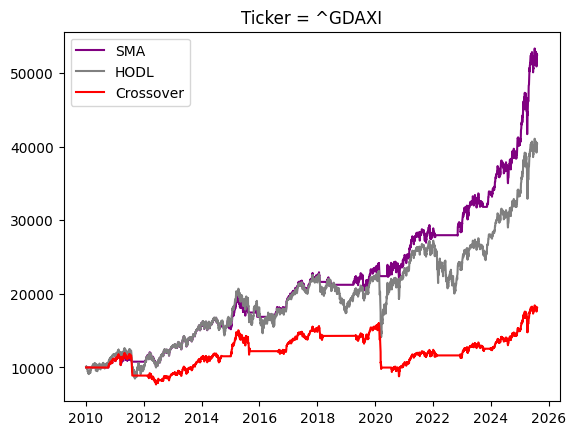

In [702]:
plt.plot(price["SMA_Capital"], color="purple", label="SMA")
plt.plot(price["HODL"], color="grey", label="HODL")
plt.plot(price["Strat_2_Capital"], color="red", label="Crossover")
plt.legend()
plt.title(f"Ticker = {ticker}")
plt.show()

In [703]:
price["Strat_2_Peak"] = np.maximum.accumulate(price["Strat_2_Capital"])
price["Strat_2_Drawdown"] = price["Strat_2_Capital"] - price["Strat_2_Peak"]

In [704]:
startegy_2 = {'roi': np.round((price["Strat_2_Capital"][-1]/price["Strat_2_Capital"][0] - 1) * 100, 2), 
        'cagr': np.round(((price["Strat_2_Capital"][-1]/price["Strat_2_Capital"][0])**(1/years) - 1) * 100, 2),
        'max_dd': np.round(np.min(price["Strat_2_Drawdown"]/price["Strat_2_Peak"]) * 100, 2)}

C:\Users\adelb\AppData\Local\Temp\ipykernel_13520\3814336775.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  startegy_2 = {'roi': np.round((price["Strat_2_Capital"][-1]/price["Strat_2_Capital"][0] - 1) * 100, 2),
C:\Users\adelb\AppData\Local\Temp\ipykernel_13520\3814336775.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'cagr': np.round(((price["Strat_2_Capital"][-1]/price["Strat_2_Capital"][0])**(1/years) - 1) * 100, 2),


In [705]:
comp_table = pd.DataFrame([hodl, startegy, startegy_2], index=["HODL", "SMA Strategy", "Moving Average Crossover"])
print(comp_table)

                             roi   cagr  max_dd
HODL                      299.50   9.28  -38.78
SMA Strategy              425.06  11.21  -15.47
Moving Average Crossover   81.47   3.89  -44.93
